# TP2 - DB Normalization and Querying

The objectives of this TP are:
1. Apply normalization 1NF -> 2NF -> 3NF
2. Perform SQL queries on the normalized database

In this TP, we will use a database **`wine.db`** (available in the course's website) containing wine information related to 'production' and 'sales'. 

> Production <---> Wine <---> Sales


---

### Working with db files in Jupyter
- Python provides an interface for SQLite through the *sqlite3* module
- The **`%%sql`** magic builds upon it (and other tools) to enable the usage of SQL commands within a Jupyter Notebook as in common SQL clients.
- Before proceeding, make sure that **`wine.db`** is in the same path as this notebook.
  - If **`wine.db`** is not in the same path, an empty **`wine.db`** file will be created, resulting in errors in later steps of the TP.
- The SQLite module in Python commits transactions automatically, this means that any change in the DB is immediately written to the file, e.g. creating/deleting tables.
  -  For this reason, it is recommended to have a backup of **`wine.db`** as it is provided in the course's website.

---

**`wine.db`** contains the following unnormalized tables:

<center>**Master1**</center>

|*Attribute*|         *Description*          |
| -------   |--------------------------------|
| NV        | Wine number                    |
| CRU       | Vineyard or group of vineyards |
| DEGRE     | Alcohol content                |
| MILL      | Vintage year                   |
| QTE       | Number of bottles harvested    |
| NP        | Producer number                |
| NOM       | Producer's last name           |
| PRENOM    | Producer's first name          |
| REGION    | Production region              |

From wikipedia:

__Cru__: Often used to indicate a specifically named and legally defined vineyard or ensemble of vineyards and the vines "which grow on [such] a reputed terroir; by extension of good quality." The term is also used to refer to the wine produced from such vines.


<center>**Master2**</center>

|*Attribute*|                         *Description*                  |
| -------   |--------------------------------------------------------|
| NV        | Wine number                                            |
| CRU       | Vineyard or group of vineyards                         |
| DEGRE     | Alcohol content                                        |
| MILL      | Vintage year                                           |
| DATES     | Buying date                                            |
| LIEU      | Place where the wine was sold                          |
| QTE       | Number of bottles bought                               |
| NB        | Client (buveur) number                                 |
| NOM       | Client's last name                                     |
| PRENOM    | Client's first name                                    |
| TYPE      | Type of client by volume of purchases                  |
| REGION    | Administrative Region (different to production region) |


In [101]:
import sqlite3    # Python interface for SQLite databases

In [102]:
def printSchema(connection):
    # Function to print the DB schema
    # Source: http://stackoverflow.com/a/35092773/4765776
    for (tableName,) in connection.execute(
        """
        select NAME from SQLITE_MASTER where TYPE='table' order by NAME;
        """
    ):
        print("{}:".format(tableName))
        for (
            columnID, columnName, columnType,
            columnNotNull, columnDefault, columnPK,
        ) in connection.execute("pragma table_info('{}');".format(tableName)):
            print("  {id}: {name}({type}){null}{default}{pk}".format(
                id=columnID,
                name=columnName,
                type=columnType,
                null=" not null" if columnNotNull else "",
                default=" [{}]".format(columnDefault) if columnDefault else "",
                pk=" *{}".format(columnPK) if columnPK else "",
            ))

In [103]:
conn = sqlite3.connect('wine.db')
c = conn.cursor()
print("Database schema:")
printSchema(conn)           # An usefull way to viualize the content of the database

Database schema:
Customer:
  0: NB(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: TYPE(TEXT)
Location:
  0: LIEU(TEXT)
  1: REGION(TEXT)
MASTER1:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: QTE(NUM)
  5: NP(NUM)
  6: NOM(TEXT)
  7: PRENOM(TEXT)
  8: REGION(TEXT)
MASTER2:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: DATES(DATE)
  5: LIEU(TEXT)
  6: QTE(NUM)
  7: NB(NUM)
  8: NOM(TEXT)
  9: PRENOM(TEXT)
  10: TYPE(TEXT)
  11: REGION(TEXT)
Producer:
  0: NP(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: REGION(TEXT)
Quantity:
  0: NV(NUM)
  1: NP(NUM)
  2: QTE(NUM)
Sales:
  0: NV(NUM)
  1: NB(NUM)
  2: QTE(NUM)
  3: DATES(NUM)
  4: LIEU(TEXT)
Wine:
  0: NV(NUM)
  1: CRU(TEXT)
  2: MILL(NUM)
  3: DEGRE(NUM)


From this point we will use __%%sql__ magic

In [3]:
%load_ext sql
%sql sqlite:///wine.db

'Connected: @wine.db'

# PART I: Database normalization

The first task on this TP is the normalization of the wine data. In its current state both tables **Master1** and **Master2** are in the First Normal Form (1NF).

By inspecting the content of these tables we can see that multiple tuples have NULL values.

In [5]:
%%sql SELECT *
FROM Master1
LIMIT 10;

Done.


NV,CRU,DEGRE,MILL,QTE,NP,NOM,PRENOM,REGION
None,None,None,None,None,3,Six,Paul,Alsace
None,None,None,None,None,6,Marmagne,Bernard,Bourgogne
None,None,None,None,None,8,Lioger d'Harduy,Gabriel,Bourgogne
None,None,None,None,None,16,Barbin,Bernard,Bourgogne
None,None,None,None,None,17,Faiveley,Guy,Bourgogne
None,None,None,None,None,18,Tramier,Jean,Bourgogne
None,None,None,None,None,19,Dupaquier,Roger,Bourgogne
None,None,None,None,None,20,Lamy,Jean,Bourgogne
None,None,None,None,None,21,Cornu,Edmond,Bourgogne
None,None,None,None,None,26,Violot,Gilbert,Bourgogne


* Notice that Jupyter *displays* 'None' instead of 'NULL'. 
  - This is only to comply with python notation.
* To account for NULL values, your SQL queries must test explicitly for 'NULL'.

Another problem in **Master1** and **Master2** is data redundancy, for example:

In [6]:
%%sql SELECT *
FROM Master1
WHERE NV = 45;

Done.


NV,CRU,DEGRE,MILL,QTE,NP,NOM,PRENOM,REGION
45,Chiroubles,None,1983,90,2,Boxler,Albert,Alsace
45,Chiroubles,None,1983,912,67,Descombes,Jean Ernest,Beaujolais
45,Chiroubles,None,1983,98,71,Chalandard,Danile,Jura
45,Chiroubles,None,1983,540,78,Michlel,Pierre Emile,Jura
45,Chiroubles,None,1983,450,86,Dumazet,Marc,Rhone


---

Additional resource for Normalization:

https://www.youtube.com/watch?v=UrYLYV7WSHM

---

#### Exercise 1.1

Convert table **Master1** to the Second Normal Form (2NF) or Third Normal Form (3NF) as applicable.
* Explain your answer
* List main functional dependencies (not all of them)
* Describe the schema of new tables and how they relate
  * You can write Tables as above or you can insert images in the notebook.
  
Remember that **`wine.db`** contains information related to wine 'production' and 'sells'.

> Production <---> Wine <---> Sales

A good start point is to look for the 'Wine' attributes.

**Hint:** Look for redundant information between the master tables.

Test to check the FD NV -> MILL

In [54]:
%%sql SELECT COUNT(DISTINCT(MILL)) as C, NV 
FROM Master1
WHERE NV IS NOT NULL
GROUP BY NV
HAVING C > 1;

 * sqlite:///wine.db
Done.


C,NV


From this query, we see there is not different MILL values for a given NV.
Thus we can conclude NV -> MILL

Tests to check that the FDs
NV -> QTE
NV -> CRU
NV -> DEGRE

In [55]:
%%sql SELECT COUNT(DISTINCT(QTE)) as C, NV 
FROM Master1
WHERE NV IS NOT NULL
GROUP BY NV
HAVING C > 1;

 * sqlite:///wine.db
Done.


C,NV
2,1
3,12
2,32
2,35
3,43
5,45
3,54
2,60
2,64
2,65


In [56]:
%%sql SELECT COUNT(DISTINCT(CRU)) as C, NV 
FROM Master1
WHERE NV IS NOT NULL
GROUP BY NV
HAVING C > 1;

 * sqlite:///wine.db
Done.


C,NV


In [57]:
%%sql SELECT COUNT(DISTINCT(DEGRE)) as C, NV 
FROM Master1
WHERE NV IS NOT NULL
GROUP BY NV
HAVING C > 1;

 * sqlite:///wine.db
Done.


C,NV


Test to confirm that FD NV -> NP does not exist

In [58]:
%%sql SELECT COUNT(DISTINCT(NP)) as C, NV 
FROM Master1
WHERE NV IS NOT NULL
GROUP BY NV
HAVING C > 1;

 * sqlite:///wine.db
Done.


C,NV
2,1
3,12
2,32
2,35
3,43
5,45
3,54
2,60
2,64
2,65


In [62]:
%%sql SELECT COUNT(DISTINCT(NV)) as C, NP 
FROM Master1
WHERE NP IS NOT NULL
GROUP BY NP
HAVING C > 1;

 * sqlite:///wine.db
Done.


C,NP
3,1
4,2
2,4
5,5
2,7
2,9
3,10
2,11
3,12
2,13


Conclusion NV -> NP is not true and NP -> NV is not true

In [117]:
%%sql SELECT COUNT(DISTINCT(NP)) as C, REGION 
FROM Master1
GROUP BY NP;

 * sqlite:///wine.db
Done.


C,REGION
0,None
1,Alsace
1,Alsace
1,Alsace
1,Alsace
1,Bourgogne
1,Bourgogne
1,Bourgogne
1,Bourgogne
1,Bourgogne


Conclusion NP -> REGION

From all these tests, we can draw the following scheme for Master 1:
NV -> CRU, MILL, DEGRE
NP -> NOM, PRENOM, REGION
QTE -> QTE

The data scheme is therefore (done with http://db.lewagon.com)
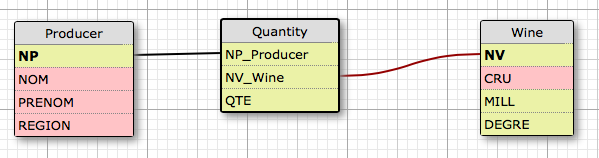

-- ---
-- Globals
-- ---

-- SET SQL_MODE="NO_AUTO_VALUE_ON_ZERO";
-- SET FOREIGN_KEY_CHECKS=0;

-- ---
-- Table 'Producer'
-- 
-- ---

DROP TABLE IF EXISTS `Producer`;
		
CREATE TABLE `Producer` (
  `NP` INTEGER NULL DEFAULT NULL,
  `NOM` CHAR NULL DEFAULT NULL,
  `PRENOM` CHAR NULL DEFAULT NULL,
  `REGION` CHAR NULL DEFAULT NULL,
  PRIMARY KEY (`NP`)
);

-- ---
-- Table 'Wine'
-- 
-- ---

DROP TABLE IF EXISTS `Wine`;
		
CREATE TABLE `Wine` (
  `NV` INTEGER NULL DEFAULT NULL,
  `CRU` CHAR NULL DEFAULT NULL,
  `MILL` INTEGER NULL DEFAULT NULL,
  `DEGRE` DECIMAL NULL DEFAULT NULL,
  PRIMARY KEY (`NV`)
);

-- ---
-- Table 'Quantity'
-- 
-- ---

DROP TABLE IF EXISTS `Quantity`;
		
CREATE TABLE `Quantity` (
  `QTE` INTEGER NULL DEFAULT NULL,
  `NP_Producer` INTEGER NULL DEFAULT NULL,
  `NV_Wine` INTEGER NULL DEFAULT NULL,
  PRIMARY KEY (`QTE`)
);

-- ---
-- Foreign Keys 
-- ---

ALTER TABLE `Quantity` ADD FOREIGN KEY (NP_Producer) REFERENCES `Producer` (`NP`);
ALTER TABLE `Quantity` ADD FOREIGN KEY (NV_Wine) REFERENCES `Wine` (`NV`);

-- ---
-- Table Properties
-- ---

-- ALTER TABLE `Producer` ENGINE=InnoDB DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
-- ALTER TABLE `Wine` ENGINE=InnoDB DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
-- ALTER TABLE `Quantity` ENGINE=InnoDB DEFAULT CHARSET=utf8 COLLATE=utf8_bin;

-- ---
-- Test Data
-- ---

-- INSERT INTO `Producer` (`NP`,`NOM`,`PRENOM`,`REGION`) VALUES
-- ('','','','');
-- INSERT INTO `Wine` (`NV`,`CRU`,`MILL`,`DEGRE`) VALUES
-- ('','','','');
-- INSERT INTO `Quantity` (`QTE`,`NP_Producer`,`NV_Wine`) VALUES
-- ('','','');

#### Exercise 1.2

Convert table **Master2** to the Second Normal Form (2NF) or Third Normal Form (3NF) as applicable.
* Explain your answer
* List main functional dependencies (not all of them)
* Describe the schema of new tables and how they relate
  * You can write Tables as above or you can insert images in the notebook.

**Note:** For this part, consider that a wine can be bought in multiple locations and multiple times per day.

<center>**Master2**</center>

|*Attribute*|                         *Description*                  |
| -------   |--------------------------------------------------------|
| NV        | Wine number                                            |
| CRU       | Vineyard or group of vineyards                         |
| DEGRE     | Alcohol content                                        |
| MILL      | Vintage year                                           |
| DATES     | Buying date                                            |
| LIEU      | Place where the wine was sold                          |
| QTE       | Number of bottles bought                               |
| NB        | Client (buveur) number                                 |
| NOM       | Client's last name                                     |
| PRENOM    | Client's first name                                    |
| TYPE      | Type of client by volume of purchases                  |
| REGION    | Administrative Region (different to production region) |



By writing such a query and running it on the various combinations of fields, we can check wether there is functional dependencies
When nothing is returned it means there is a functional dependency K -> C

In [80]:
%%sql SELECT COUNT(DISTINCT(QTE)) as C, DATES as K
FROM Master2
WHERE K IS NOT NULL
GROUP BY K
HAVING C > 1;

 * sqlite:///wine.db
Done.


C,K
2,1980-12-31
3,1982-11-05
3,1983-05-05
2,1987-12-24
18,2015-10-16


We have the functional dependencies
NV -> CRU, DEGRE, MILL
NB -> NOM, PRENOM, TYPE
LIEU -> REGION
DATES
QTE

In [83]:
%%sql SELECT DISTINCT(TYPE) as C, QTE as K
FROM Master2
WHERE K IS NOT NULL;

 * sqlite:///wine.db
Done.


C,K
moyen,33
petit,1
moyen,2
moyen,6
petit,5
gros,12
petit,6
moyen,4
moyen,50
gros,36


Note that it seems there is no functional dependency f(QTE) -> TYPE where f would be an indication of the quantity bought by a customer

The relational data model scheme for Master 2 is therefore
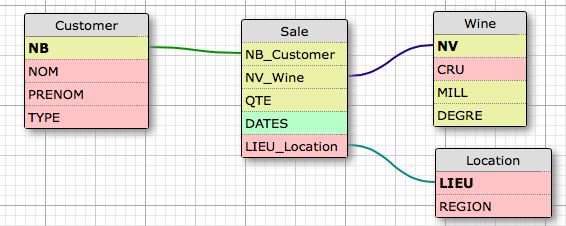

As Wine is the same between Master 1 and Master 2, the overall relational scheme will be 
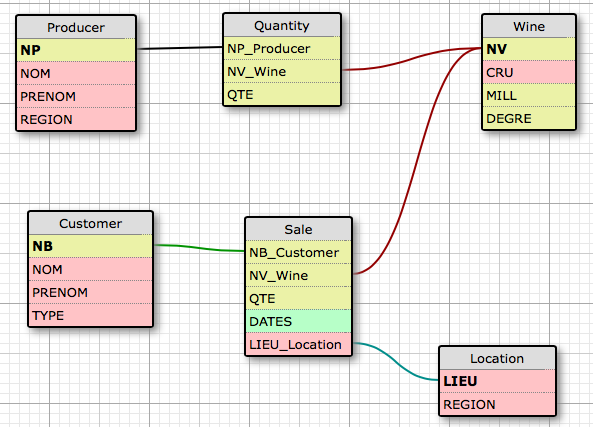

Once you have defined the 2NF or 3NF (as applicable) we need to split the data into new tables.

A table can be created from the result of a query.

In the following example we will create a new table "dummy" to store the different values of alcohol content.

In [7]:
%%sql DROP TABLE IF EXISTS dummy;

-- Create dummy table
CREATE TABLE dummy AS
SELECT DISTINCT DEGRE
FROM MASTER1;

Done.
Done.


[]

In [100]:
print("\nContent of the database")
printSchema(conn)


Content of the database


NameError: name 'conn' is not defined

In [9]:
%%sql
SELECT *
FROM dummy;

Done.


DEGRE
None
11.5
11.3
12.1
10.9
11.7
11.2
12.3
11.9
11.8


Looking into "dummy", we notice that our query includes NULL. This is not allowed if we were to use DEGRE as key for a table.

To correct this, we need to change the query to explicitly test for NULL as follows:

In [10]:
%%sql DROP TABLE IF EXISTS dummy;

-- Create dummy table
CREATE TABLE dummy AS
SELECT DISTINCT DEGRE
FROM MASTER1
WHERE DEGRE IS NOT NULL;

SELECT *
FROM dummy;

Done.
Done.
Done.


DEGRE
11.5
11.3
12.1
10.9
11.7
11.2
12.3
11.9
11.8
10.7


Notice that we use `NULL` given that `None` is only used for display.

In [11]:
# Remove "dummy" table
%sql DROP TABLE IF EXISTS dummy;

Done.


[]

#### Exercise 1.3

Create the new tables from Master1:

In [93]:
%%sql DROP TABLE IF EXISTS Wine;

-- Create Wine table
CREATE TABLE Wine AS
SELECT DISTINCT NV, CRU, MILL, DEGRE
FROM MASTER1
WHERE NV IS NOT NULL
ORDER BY NV;

SELECT *
FROM Wine;

 * sqlite:///wine.db
Done.
Done.
Done.


NV,CRU,MILL,DEGRE
1,Mercurey,1980,11.5
2,Julienas,1974,11.3
3,Savigny les Beaunes,1978,12.1
4,Mercurey,1980,10.9
5,Pommard,1976,11.7
6,Mercurey,1981,11.2
7,Grands Echezeaux,1968,11.7
8,Cotes de Beaune Villages,1975,12.3
9,Chapelle Chambertin,1973,11.9
10,Beaujolais Villages,1979,11.8


In [94]:
%%sql DROP TABLE IF EXISTS Producer;

-- Create Producer table
CREATE TABLE Producer AS
SELECT DISTINCT NP, NOM, PRENOM, REGION
FROM MASTER1
WHERE NP IS NOT NULL
ORDER BY NP;

SELECT *
FROM Producer;

 * sqlite:///wine.db
Done.
Done.
Done.


NP,NOM,PRENOM,REGION
1,Bohn,Rene,Alsace
2,Boxler,Albert,Alsace
3,Six,Paul,Alsace
4,Stentz,Fernand,Alsace
5,Joudeat,Lucien,Bourgogne
6,Marmagne,Bernard,Bourgogne
7,Lasnier,Pierre,Bourgogne
8,Lioger d'Harduy,Gabriel,Bourgogne
9,Moniot,Gilbert,Bourgogne
10,Fournier,Jean Claude,Bourgogne


In [89]:
%%sql DROP TABLE IF EXISTS Quantity;

-- Create Quantity table
CREATE TABLE Quantity AS
SELECT DISTINCT NV, NP, QTE
FROM MASTER1
WHERE NV IS NOT NULL AND NP IS NOT NULL;

SELECT *
FROM Quantity;

 * sqlite:///wine.db
Done.
Done.
Done.


NV,NP,QTE
1,1,300
1,73,1
2,5,100
3,1,400
4,10,35
5,30,46
6,42,300
7,98,60
8,90,12
10,98,100


#### Exercise 1.4

Create the new tables from Master2:

In [95]:
%%sql DROP TABLE IF EXISTS Wine;

-- Create Wine table
CREATE TABLE Wine AS
SELECT DISTINCT NV, CRU, MILL, DEGRE
FROM MASTER2
WHERE NV IS NOT NULL
ORDER BY NV;

SELECT *
FROM Wine;

 * sqlite:///wine.db
Done.
Done.
Done.


NV,CRU,MILL,DEGRE
1,Mercurey,1980,11.5
2,Julienas,1974,11.3
3,Savigny les Beaunes,1978,12.1
4,Mercurey,1980,10.9
5,Pommard,1976,11.7
6,Mercurey,1981,11.2
7,Grands Echezeaux,1968,11.7
8,Cotes de Beaune Villages,1975,12.3
9,Chapelle Chambertin,1973,11.9
10,Beaujolais Villages,1979,11.8


In [92]:
%%sql DROP TABLE IF EXISTS Customer;

-- Create Customer table
CREATE TABLE Customer AS
SELECT DISTINCT NB, NOM, PRENOM, TYPE
FROM MASTER2
WHERE NB IS NOT NULL
ORDER BY NB;

SELECT *
FROM Customer;

 * sqlite:///wine.db
Done.
Done.
Done.


NB,NOM,PRENOM,TYPE
1,Aristote,None,petit
2,Artaud,Antonin,moyen
3,Aron,Raymond,gros
4,Apollinaire,Guillaume,moyen
5,Audiberti,Jacques,petit
6,Arrabal,Fernando,gros
7,Anouilh,Jean,moyen
8,Aragon,Louis,gros
9,Ajar,Emile,petit
10,Andersen,Yann,gros


In [96]:
%%sql DROP TABLE IF EXISTS Location;

-- Create Customer table
CREATE TABLE Location AS
SELECT DISTINCT LIEU, REGION
FROM MASTER2
WHERE LIEU IS NOT NULL
ORDER BY LIEU;

SELECT *
FROM Location;

 * sqlite:///wine.db
Done.
Done.
Done.


LIEU,REGION
BORDEAUX,NOUVELLE-AQUITAINE
CAEN,NORMANDIE
CANNES,PROVENCE-ALPES-CÔTE D'AZUR
CHALON SUR SAONE,BOURGOGNE-FRANCHE-COMTÉ
DIJON,BOURGOGNE-FRANCHE-COMTÉ
LE CHESNAY,ÎLE-DE-FRANCE
LILLE,HAUTS-DE-FRANCE
LYON,AUVERGNE-RHÔNE-ALPES
MERCUREY,BOURGOGNE-FRANCHE-COMTÉ
NANCY,GRAND EST


In [98]:
%%sql DROP TABLE IF EXISTS Sales;

-- Create Sales table
CREATE TABLE Sales AS
SELECT NV, NB, QTE, DATES, LIEU
FROM MASTER2
WHERE NV IS NOT NULL;

SELECT *
FROM Sales;

 * sqlite:///wine.db
Done.
Done.
Done.


NV,NB,QTE,DATES,LIEU
1,2,33,1977-11-02,BORDEAUX
1,44,1,2015-10-16,PARIS
1,45,1,1983-12-31,RENNES
2,48,2,1983-12-25,LYON
3,7,6,1978-11-01,NICE
3,49,5,1987-12-24,MERCUREY
4,8,12,1982-11-05,TOULOUSE
4,44,6,2015-10-16,PARIS
4,50,4,1981-06-29,SENS
5,2,50,1984-11-04,MERCUREY


In [104]:
print("\nContent of the database")
printSchema(conn)


Content of the database
Customer:
  0: NB(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: TYPE(TEXT)
Location:
  0: LIEU(TEXT)
  1: REGION(TEXT)
MASTER1:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: QTE(NUM)
  5: NP(NUM)
  6: NOM(TEXT)
  7: PRENOM(TEXT)
  8: REGION(TEXT)
MASTER2:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: DATES(DATE)
  5: LIEU(TEXT)
  6: QTE(NUM)
  7: NB(NUM)
  8: NOM(TEXT)
  9: PRENOM(TEXT)
  10: TYPE(TEXT)
  11: REGION(TEXT)
Producer:
  0: NP(NUM)
  1: NOM(TEXT)
  2: PRENOM(TEXT)
  3: REGION(TEXT)
Quantity:
  0: NV(NUM)
  1: NP(NUM)
  2: QTE(NUM)
Sales:
  0: NV(NUM)
  1: NB(NUM)
  2: QTE(NUM)
  3: DATES(NUM)
  4: LIEU(TEXT)
Wine:
  0: NV(NUM)
  1: CRU(TEXT)
  2: MILL(NUM)
  3: DEGRE(NUM)


# PART II: SQL QUERIES

In the second part of this TP you will create SQL queries to retrieve information from the database.

**Important:**

- You MUST use the normalized tables created in previous steps.
  - The normalized tables will also be used in TP3.
- Do NOT use **Master1** and **Master2** in your queries.

#### Exercise 2.1

What are the different types of clients (buveurs) by volume of purchases?

In [164]:
%%sql
SELECT DISTINCT(NB), TYPE, NOM, SUM(QTE)
FROM Master2
WHERE QTE > 0
GROUP BY NB;

 * sqlite:///wine.db
Done.


NB,TYPE,NOM,SUM(QTE)
1,petit,Aristote,78
2,moyen,Artaud,583
3,gros,Aron,58
4,moyen,Apollinaire,24
5,petit,Audiberti,113
6,gros,Arrabal,36
7,moyen,Anouilh,6
8,gros,Aragon,132
9,petit,Ajar,140
10,gros,Andersen,1


In [106]:
%%sql 
SELECT DISTINCT TYPE
FROM Customer

 * sqlite:///wine.db
Done.


TYPE
petit
moyen
gros


#### Exercise 2.2

What regions produce Pommard or Brouilly?

In [108]:
%%sql
SELECT P.REGION, W.CRU
FROM Producer as P, Wine as W, Quantity as Q
WHERE P.NP = Q.NP AND Q.NV = W.NV AND W.CRU IN ('Pommard', 'Brouilly')

 * sqlite:///wine.db
Done.


REGION,CRU
Bourgogne,Pommard
Rhone,Pommard
Bourgogne,Brouilly


#### Exercise 2.3

What regions produce Pommard and Brouilly?

In [167]:
%%sql
SELECT P.REGION
FROM Producer as P, Wine as W, Quantity as Q
WHERE P.NP = Q.NP AND Q.NV = W.NV AND W.CRU = 'Pommard'
INTERSECT
SELECT P.REGION
FROM Producer as P, Wine as W, Quantity as Q
WHERE P.NP = Q.NP AND Q.NV = W.NV AND W.CRU = 'Brouilly';

 * sqlite:///wine.db
Done.


REGION
Bourgogne


#### Exercise 2.4

Get the number of wines bought by CRU and Millésime

In [129]:
%%sql
SELECT CRU, MILL, SUM(QTE) AS TOTAL
FROM Wine as W, Sales as S
WHERE W.NV = S.NV AND QTE > 0
GROUP BY W.CRU;

 * sqlite:///wine.db
Done.


CRU,MILL,TOTAL
Arbois,1980,8
Auxey Duresses,1914,80
Beaujolais Primeur,1983,7
Beaujolais Villages,1978,780
Chapelle Chambertin,1973,30
Chateau Corton Grancey,1980,4
Chenas,1984,1
Clairette de Die,1976,5
Cornas,1980,25
Cote de Brouilly,1980,23


#### Exercise 2.5

Retrieve the wine number (NV) of wines produced by more than three producers

In [137]:
%%sql
SELECT NV, COUNT(NP)
FROM Quantity
GROUP BY NV
HAVING COUNT(NP) > 3; 

 * sqlite:///wine.db
Done.


NV,COUNT(NP)
45,5
78,5
89,4
98,5


#### Exercise 2.6

Which producers have not produced any wine?

In [139]:
%%sql
SELECT NP, NOM, PRENOM
FROM Producer
WHERE NP NOT IN
(SELECT DISTINCT NP 
FROM Quantity)

 * sqlite:///wine.db
Done.


NP,NOM,PRENOM
3,Six,Paul
6,Marmagne,Bernard
8,Lioger d'Harduy,Gabriel
16,Barbin,Bernard
17,Faiveley,Guy
18,Tramier,Jean
19,Dupaquier,Roger
20,Lamy,Jean
21,Cornu,Edmond
26,Violot,Gilbert


#### Exercise 2.7

What clients (buveurs) have bought at least one wine from 1980?

In [147]:
%%sql
SELECT NB, NOM, PRENOM
FROM Customer
WHERE NB IN
(SELECT NB
FROM Sales
WHERE NV IN 
(SELECT NV
FROM Wine
WHERE MILL = 1980))

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM
2,Artaud,Antonin
8,Aragon,Louis
44,Gide,Andre
45,Giono,Jean
50,Lautreamont,None
61,Mallarme,Stephane


#### Exercise 2.8

What clients (buveurs) have NOT bought any wine from 1980?

In [148]:
%%sql
SELECT NB, NOM, PRENOM
FROM Customer
WHERE NB NOT IN
(SELECT NB
FROM Sales
WHERE NV IN 
(SELECT NV
FROM Wine
WHERE MILL = 1980))

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM
1,Aristote,None
3,Aron,Raymond
4,Apollinaire,Guillaume
5,Audiberti,Jacques
6,Arrabal,Fernando
7,Anouilh,Jean
9,Ajar,Emile
10,Andersen,Yann
11,Breton,Andre
12,Bataille,Georges


#### Exercise 2.9

What clients (buveurs) have bought ONLY wines from 1980?

Use of EXCEPT to keep the results from query 1 which are not in the result from query 2

In [172]:
%%sql
SELECT NB, NOM, PRENOM
FROM Customer
WHERE NB IN
(SELECT NB
FROM Sales
WHERE NV IN 
(SELECT NV
FROM Wine
WHERE MILL = 1980))
EXCEPT
SELECT NB, NOM, PRENOM
FROM Customer
WHERE NB IN
(SELECT NB
FROM Sales
WHERE NV NOT IN 
(SELECT NV
FROM Wine
WHERE MILL = 1980));

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM
44,Gide,Andre
45,Giono,Jean
50,Lautreamont,None


#### Exercise 2.10

List all wines from 1980

In [158]:
%%sql
SELECT *
FROM Wine
WHERE MILL = 1980

 * sqlite:///wine.db
Done.


NV,CRU,MILL,DEGRE
1,Mercurey,1980,11.5
4,Mercurey,1980,10.9
16,Meursault,1980,12.1
20,Cote de Brouilly,1980,12.1
26,Chateau Corton Grancey,1980,None
28,Volnay,1980,11
43,Fleurie,1980,11.4
74,Arbois,1980,12
78,Etoile,1980,12
79,Seyssel,1980,11


#### Exercise 2.11

What are the wines from 1980 bought by NB=2?

In [159]:
%%sql
SELECT *
FROM Wine
WHERE MILL = 1980 AND NV IN
(SELECT NV
FROM Sales
WHERE NB = 2)

 * sqlite:///wine.db
Done.


NV,CRU,MILL,DEGRE
1,Mercurey,1980,11.5


#### Exercise 2.12

What clients (buveurs) have bought ALL the wines from 1980?

#### faire un count de NV en 1980 à comparer à un count de NV de 1980 des acheteurs

In [176]:
%%sql
SELECT Customer.NB, NOM, PRENOM
FROM Customer, Sales
WHERE Customer.NB IN
(SELECT NB
FROM Sales
WHERE NV IN 
(SELECT NV
FROM Wine
WHERE MILL = 1980))
AND COUNT(Sales.NV) IN 
(SELECT COUNT(NV)
FROM Wine
WHERE MILL = 1980);

 * sqlite:///wine.db
(sqlite3.OperationalError) misuse of aggregate function COUNT() [SQL: 'SELECT Customer.NB, NOM, PRENOM\nFROM Customer, Sales\nWHERE Customer.NB IN\n(SELECT NB\nFROM Sales\nWHERE NV IN \n(SELECT NV\nFROM Wine\nWHERE MILL = 1980))\nAND COUNT(Sales.NV) IN \n(SELECT COUNT(NV)\nFROM Wine\nWHERE MILL = 1980);'] (Background on this error at: http://sqlalche.me/e/e3q8)


In [196]:
%%sql
SELECT NB, NOM, PRENOM
FROM Customer
WHERE NB IN
(SELECT NB
FROM Sales
WHERE NV IN 
(SELECT NV
FROM Wine
WHERE MILL = 1980)
GROUP BY NB
HAVING COUNT(DISTINCT NV) IN 
(SELECT COUNT(NV)
FROM Wine
WHERE MILL = 1980));

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM
44,Gide,Andre
